(784, 10000)
(10000,)
(784, 60000)
(60000,)


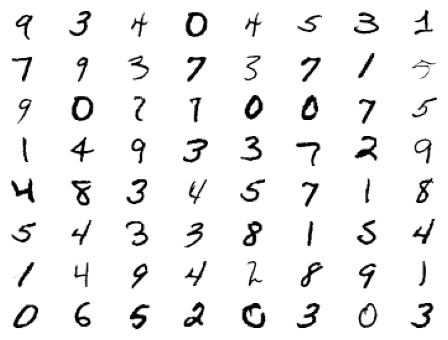

In [12]:
##imports from libraries
import pandas as pd
import numpy as np
import time
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import resource
import time
from datetime import datetime
import math
import os
from sklearn import preprocessing
import sys
import cvxpy
from multiprocessing import Process, Pipe
from multiprocessing.pool import ThreadPool

import keras
from keras.datasets import mnist
from random import randint
from sklearn.metrics import mean_absolute_error

## Preprocessing of data
# Load data here:

# Preparing the dataset
# Setup train and test splits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Making a copy before flattening for the next code-segment which displays images
x_train_drawing = x_train

image_size = 784 # 28 x 28
x_train = x_train.reshape(x_train.shape[0], image_size).T / 255.0
x_test = x_test.reshape(x_test.shape[0], image_size).T / 255.0

# Convert class vectors to binary class matrices (One-hot)
num_classes = 10
# y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

# Show some random digits
for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    ax.axis('off')
    plt.imshow(x_train_drawing[randint(0, x_train.shape[0])], cmap='Greys')

# #Split dataset to 10 partitions
def split_workers(X_data, y_data, num_worker):
    # Split into 10 subdatasets for 10 workers
    data_X_list=[]
    data_y_list=[]
    num_data = len(y_data)
    num_per_data = num_data // num_worker
    for i_th in range(num_worker):
        j = num_per_data * (i_th + 1)
        i = i_th*num_per_data
        x_data_worker = X_data.T[i:j]
        y_data_worker = y_data[i:j]
        data_X_list.append(x_data_worker.T)
        data_y_list.append(y_data_worker)
        
    return data_X_list, data_y_list

num_worker = 10
x_train_list, y_train_list = split_workers(x_train, y_train, num_worker)
x_test_list, y_test_list = split_workers(x_test, y_test, num_worker)

print(x_test.shape)
print(y_test.shape)
print(x_train.shape)
print(y_train.shape)

In [13]:
#multiclass SVM classification loss and its gradient
def SVM_classify(x, w):
    return np.argmax(np.matmul(x.T, w), axis = 1).reshape(x.shape[1], 1)

def SVM_cost(x, y, w):
    svm_cost = (np.matmul(x.T, w) - np.repeat(np.multiply(x.T, w[:,y.reshape(y.shape[0])].T).sum(axis = 1).reshape(y.shape[0], 1), 10, axis = 1) + delta).clip(min = 0)
    svm_cost[(range(y.shape[0]), y.reshape(y.shape[0]))] = 0
    return svm_cost

def regulated_total_cost(x, y, w, lambda_):
    return SVM_cost(x, y, w).mean() + lambda_/2 * np.linalg.norm(w)**2
    # return SVM_cost(x, y, w).sum()

def SVM_cost_grad(x, y, w, lambda_):
    svm_cost = SVM_cost(x, y, w)
    svm_cost[svm_cost > 0] = 1
    svm_cost_grad_coef = svm_cost
    svm_cost_grad_coef[(range(y.shape[0]), y.reshape(y.shape[0]))] -= svm_cost.sum(axis=1)
    svm_cost_grad = np.zeros((x.shape[0], 10))
    for i in range(10):
        svm_cost_grad[:, i] = np.multiply(svm_cost_grad_coef[:, i].reshape(svm_cost_grad_coef.shape[0], 1), x.T).sum(axis = 0)
    return svm_cost_grad



#binary SVM classification one-vs-rest loss and its gradient
def bin_SVM_classify(x, w):
    scores = np.matmul(x.T, w)
    class_votes = np.zeros(scores.shape)
    class_votes[scores > 0] += 1
    for i in range(10):
        class_votes[scores[:,i] <= 0,:] += 1
    class_votes[scores <= 0] -= 1
    return np.argmax(class_votes, axis = 1).reshape(x.shape[1], 1)

def bin_SVM_cost(x, y, w):
    svm_cost = - np.matmul(x.T, w) 
    svm_cost[(range(y.shape[0]), y.reshape(y.shape[0]))] *= -1
    return (1 - svm_cost).clip(min = 0)

def bin_regulated_total_cost(x, y, w, lambda_):
    return bin_SVM_cost(x, y, w).mean(axis = 0) + lambda_/2 * np.linalg.norm(w, axis = 0)**2

def bin_SVM_cost_grad(x, y, w, lambda_):
    svm_cost = bin_SVM_cost(x, y, w)
    svm_cost[svm_cost > 0] = 1
    svm_cost_grad = np.zeros((x.shape[0], 10))
    for i in range(10):
        svm_cost_yi = svm_cost[:, i]
        svm_cost_yi[y == i] *= -1
        svm_cost_grad[:, i] = np.multiply(x, svm_cost_yi).sum(axis = 1) + lambda_ * w[:, i]
    return svm_cost_grad



#single agent GD SVM
def gradient_descent(x, y, w_k, lambda_, a_k, max_iter): 
    L1 = regulated_total_cost(x, y, w_k, lambda_)
    errs = []
    for k in range(max_iter):
        L = L1
        grad_w = SVM_cost_grad(x, y, w_k, lambda_)
        w_k = w_k - a_k * grad_w
        L1 = regulated_total_cost(x, y, w_k, lambda_)
        # print([k,L1])
        errs.append(L1)
    return w_k.reshape(x.shape[0],10), errs 

def SVM_evaluate(x, y, w_k):
    y_est = SVM_classify(x, w_k)
    nCorr = 0
    for i in range(len(y)):
        if y[i] == y_est[i]:
            nCorr += 1
    return nCorr/len(y)


#single agent binary GD SVM
def bin_gradient_descent(x, y, w_k, lambda_, a_k, max_iter):
    L1 = np.linalg.norm(bin_regulated_total_cost(x, y, w_k, lambda_))
    errs = []
    for k in range(max_iter):
        L = L1
        grad_w = bin_SVM_cost_grad(x, y, w_k, lambda_)
        w_k = w_k - a_k * grad_w
        L1 = np.linalg.norm(bin_regulated_total_cost(x, y, w_k, lambda_))
        # print([k,L1])
        errs.append(L1)
    return w_k.reshape(x.shape[0],10), errs

In [14]:
# lambda_ = 1e-3
lambda_ = 1e-6
a_k = 1e-3
max_iter = 50
delta = 0.02
var = 0.02
p = 0.2
rho = 0.1
w_k = np.random.rand(x_train.shape[0], num_classes)

In [ ]:
# wk_temp, errs = gradient_descent(x_train, y_train, w_k, lambda_, a_k, max_iter)
# print(SVM_evaluate(x_test, y_test, wk_temp))

In [15]:
## CA5---------------------------- Part (a)------------------------------------------------------------------------------

#Each worker computes 10 svm loss gradients based w.r.t w for 10 classes for its partition of data adding noise with variance var :
def decentralized_gradient_descent_worker(x, y, w_k, lambda_):
    noise = np.random.normal(0, var)

    ## compute the gradients ----------------------------------------
    grad_w = SVM_cost_grad(x, y, w_k, lambda_)
    return grad_w + noise * (np.random.uniform(0,1) >= p)


def decentralized_gradient_descent_worker_(args):
    return decentralized_gradient_descent_worker(*args)


#Master updates the gradient w.r.t w_k for each class
def decentralized_gradient_descent_master(w_k, a_k, grad_w, x, y, lambda_):
    ## compute w_k --------------------------------------------------
    for i in range(10):
        w_k -= a_k / 10 * grad_w[i]
    return 10, w_k


#DGD
def decentralized_gradient_descent(x, y, workers_x, workers_y, lambda_, a_k, max_iter, master, worker_, compress = None):
    #each class has a w_k
    w_k = np.random.rand(x.shape[0], 10)
    T = 0
    sigs = []
    errs = []
    L1 = regulated_total_cost(x, y, w_k, lambda_)
    for k in range(max_iter):
        L = L1
        #copy w_k of classes for workers
        if compress is not None:
            w_k = compress(w_k)
        workers_w_k = np.array(10 * [w_k]).reshape(10, x.shape[0], 10)
        
        #each worker gets a copy of w_ks for 10 classes, and its share of data and returns 10 loss gradients, one per class
        zipped = zip(workers_x, workers_y, workers_w_k, 10 * [lambda_])
        
        pool = ThreadPool(10)
        results = pool.map(worker_, zipped)
        pool.close()
        pool.join()
        
        ## complete signal, grad_w ---------------------
        signals, grad_w = 10 * len(results), results 
        grad_w = np.array(grad_w)
        
        ## calculate T ---------------------------------
        T += signals
        if compress is not None:
            for i in range(10):
                grad_w[i] = compress(grad_w[i])
                
        #master updates w_ks
        
        ## complete signal, grad_w ---------------------
        signals, w_k = master(w_k, a_k, grad_w, x, y, lambda_) 
        ## calculate T
        T += signals
        
        L1 = regulated_total_cost(x, y, w_k, lambda_)
        errs.append(L1)
        sigs.append(T)
    print("Final loss = %.3f and gradient norm = %.3f" %(L1, np.linalg.norm(grad_w)))
    return w_k.reshape(x.shape[0],10), errs, sigs

Final loss = 0.227 and gradient norm = 2505.521
Training classification accuracy: 0.889
Test classification accuracy: 0.892


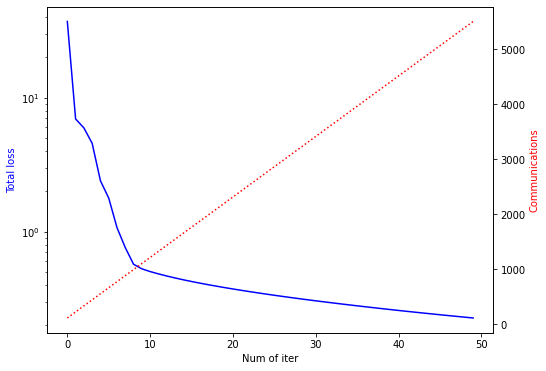

In [16]:
w_k, errs, sigs = decentralized_gradient_descent(x_train, y_train, x_train_list, y_train_list, lambda_, a_k, max_iter, decentralized_gradient_descent_master, decentralized_gradient_descent_worker_, compress = None)
print("Training classification accuracy: %.3f" % SVM_evaluate(x_train, y_train, w_k))
print("Test classification accuracy: %.3f" % SVM_evaluate(x_test, y_test, w_k))

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

x_axis = np.arange(0, max_iter)
fig,ax1 = plt.subplots()
plt.xlabel('Num of iter')

# for i in range(len(Loss_var)):
ax1.semilogy(x_axis, errs, c = "b", ls = "-")
ax1.set_ylabel('Total loss', color = "b")
# plt.legend(loc='upper right', prop={'size': 10 })

ax2 = ax1.twinx()
ax2.plot(x_axis, sigs, c = "r", ls = ":") 
ax2.set_ylabel('Communications', color = "r")

plt.savefig('CA5-1.png')
plt.show()

In [17]:
## CA5---------------------------- Part (b)------------------------------------------------------------------------------

#Master updates the gradient w.r.t w_k for each class
def decentralized_subgradient_descent_master_star(w_kl, w_kr, a_k, grad_wl, grad_wr):
    ## compute w_k --------------------------------------------------
    for i in range(5):
        w_kl -= a_k / 5 * grad_wl[i]
        w_kr -= a_k / 5 * grad_wr[i]
    return 10, w_kl, w_kr


#DGD
def decentralized_subgradient_descent_star(x, y, workers_x, workers_y, lambda_, a_k, max_iter, master, worker_, compress = None):
    #each class has a w_k
    w_kl = np.random.rand(x.shape[0], 10)
    w_kr = np.random.rand(x.shape[0], 10)
    w_k = 0.5 * (w_kl + w_kr)
    T = 0
    sigs = []
    errs = []
    L1 = regulated_total_cost(x, y, w_k, lambda_)
    workers_xl = workers_x[0:5]
    workers_yl = workers_y[0:5]
    workers_xr = workers_x[5:10]
    workers_yr = workers_y[5:10]
    for k in range(max_iter):
        L = L1
        #copy w_k of classes for workers
        if compress is not None:
            w_k = compress(w_k)
        workers_w_k = np.array(10 * [w_k]).reshape(10, x.shape[0], 10)
        

        # Left Topology
        workers_w_k_l = workers_w_k[0:5]
        #each worker gets a copy of w_ks for 10 classes, and its share of data and returns 10 loss gradients, one per class
        zipped = zip(workers_xl, workers_yl, workers_w_k_l, 5 * [lambda_])
        
        pool = ThreadPool(5)
        results = pool.map(worker_, zipped)
        pool.close()
        pool.join()
        
        ## complete signal, grad_w ---------------------
        signals, grad_wl = 5 * len(results), results 
        grad_wl = np.array(grad_wl)


        # Right Topology
        workers_w_k_r = workers_w_k[5:10]
        #each worker gets a copy of w_ks for 10 classes, and its share of data and returns 10 loss gradients, one per class
        zipped = zip(workers_xr, workers_yr, workers_w_k_r, 5 * [lambda_])
        
        pool = ThreadPool(5)
        results = pool.map(worker_, zipped)
        pool.close()
        pool.join()
        
        ## complete signal, grad_w ---------------------
        signals, grad_wr = 5 * len(results), results 
        grad_wr = np.array(grad_wr)
        
        ## calculate T ---------------------------------
        T += signals
        if compress is not None:
            for i in range(10):
                grad_w[i] = compress(grad_w[i])
                
        #master updates w_ks
        
        ## complete signal, grad_w ---------------------
        signals, w_kl, w_kr = master(w_kl, w_kr, a_k, grad_wl, grad_wr) 
        w_k = 0.5 * (w_kl + w_kr)
        ## calculate T
        T += signals
        
        L1 = regulated_total_cost(x, y, w_k, lambda_)
        errs.append(L1)
        sigs.append(T)

    grad_w = np.vstack((grad_wl, grad_wr))
    print("Final loss = %.3f and gradient norm = %.3f" %(L1, np.linalg.norm(grad_w)))
    return w_k.reshape(x.shape[0],10), errs, sigs


Final loss = 0.211 and gradient norm = 2464.835
Training classification accuracy: 0.890
Test classification accuracy: 0.892


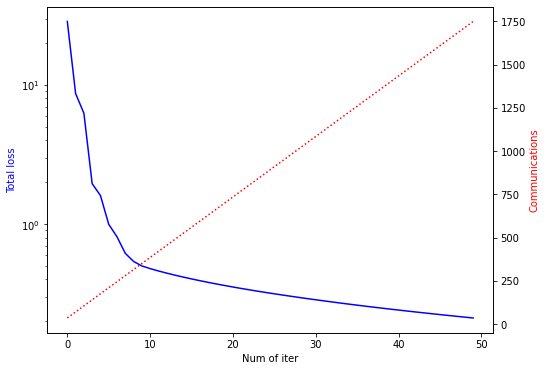

In [18]:
w_k, errs, sigs = decentralized_subgradient_descent_star(x_train, y_train, x_train_list, y_train_list, lambda_, a_k, max_iter, decentralized_subgradient_descent_master_star, decentralized_gradient_descent_worker_, compress = None)
print("Training classification accuracy: %.3f" % SVM_evaluate(x_train, y_train, w_k))
print("Test classification accuracy: %.3f" % SVM_evaluate(x_test, y_test, w_k))

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

x_axis = np.arange(0, max_iter)
fig,ax1 = plt.subplots()
plt.xlabel('Num of iter')

# for i in range(len(Loss_var)):
ax1.semilogy(x_axis, errs, c = "b", ls = "-")
ax1.set_ylabel('Total loss', color = "b")
# plt.legend(loc='upper right', prop={'size': 10 })

ax2 = ax1.twinx()
ax2.plot(x_axis, sigs, c = "r", ls = ":") 
ax2.set_ylabel('Communications', color = "r")

plt.savefig('CA5-1.png')
plt.show()

In [19]:
# ADMM

# Workers
def ADMM_worker(x, y, w_k, lambda_, rho, z_k, u_k):
    noise = np.random.normal(0, var)

    ## compute the gradients ----------------------------------------
    grad_w = SVM_cost_grad(x, y, w_k, lambda_)
    z_k = np.array(z_k)
    u_k = np.array(u_k)
    z_k_i = z_k + u_k - w_k / rho
    return grad_w + rho * z_k_i + noise * (np.random.uniform(0,1) >= p)


def ADMM_worker_(args):
    return ADMM_worker(*args)

def projection(w):
    norm = np.linalg.norm(w)
    if norm <= 1:
        return w
    else:
        return w / norm

#Master updates the gradient w.r.t w_k for each class
def ADMM_master(w_k, a_k, grad_w, x, rho, z_k, u_k):
    ## compute w_k --------------------------------------------------
    z_k_new = np.zeros((x.shape[0], 10))
    for i in range(10):
        w_k[:, i] = np.linalg.inv(x @ x.T + rho * np.eye(x.shape[0])) @ (x @ (grad_w[i] - z_k[:, i] + w_k[:, i] / rho) + rho * a_k * np.ones(x.shape[0]) / 10)
        z_k_new[:, i] = projection(w_k[:, i] + u_k[:, i] / rho)
    u_k_new = u_k + rho * (z_k - z_k_new)
    return 10, w_k, z_k_new, u_k_new


#DGD
def ADMM(x, y, workers_x, workers_y, lambda_, a_k, max_iter, master, worker_, compress = None):
    #each class has a w_k
    w_k = np.random.rand(x.shape[0], 10)
    z_k = np.random.rand(x.shape[0], 10)
    u_k = np.random.rand(x.shape[0], 10)
    T = 0
    sigs = []
    errs = []
    L1 = regulated_total_cost(x, y, w_k, lambda_)
    for k in range(max_iter):
        L = L1
        #copy w_k of classes for workers
        if compress is not None:
            w_k = compress(w_k)
        workers_w_k = np.array(10 * [w_k]).reshape(10, x.shape[0], 10)
        

        #each worker gets a copy of w_ks for 10 classes, and its share of data and returns 10 loss gradients, one per class
        zipped = zip(workers_x, workers_y, workers_w_k, 10 * [lambda_], 10 * [rho], z_k, u_k)
        
        pool = ThreadPool(10)
        results = pool.map(worker_, zipped)
        pool.close()
        pool.join()
        
        ## complete signal, grad_w ---------------------
        signals, grad_w = 10 * len(results), results 
        grad_w = np.array(grad_w)

        
        ## calculate T ---------------------------------
        T += signals
        if compress is not None:
            for i in range(10):
                grad_w[i] = compress(grad_w[i])
                
        #master updates w_ks
        
        ## complete signal, grad_w ---------------------
        signals, w_k = master(w_k, a_k, grad_w, x, rho, z_k, u_k) 
        ## calculate T
        T += signals
        
        L1 = regulated_total_cost(x, y, w_k, lambda_)
        errs.append(L1)
        sigs.append(T)
    print("Final loss = %.3f and gradient norm = %.3f" %(L1, np.linalg.norm(grad_w)))
    return w_k.reshape(x.shape[0],10), errs, sigs

In [ ]:
w_k, errs, sigs = ADMM(x_train, y_train, x_train_list, y_train_list, lambda_, a_k, max_iter,ADMM_master, ADMM_worker_, compress = None)
print("Training classification accuracy: %.3f" % SVM_evaluate(x_train, y_train, w_k))
print("Test classification accuracy: %.3f" % SVM_evaluate(x_test, y_test, w_k))